# Feature selection

#### This notebook has been created by Rosanna Turrisi (rosanna.turrisi@edu.unige.it) for students and young reasearchers approaching to Machine Learning in Medicine.

The goal of this notebook is to understand the importance of feature selection and how to perform it. We will compare the main approches to select relevant features, which are Filter methods, Recursive Feature Elimination, Regularization methods. The Python script will take you through the following steps:  
 - Installing packages and importing libraries,
 - Reading the data and the outcomes, 
 - Remove redundand features and perform Feature Selection: , 
 - Creating the classification model per each feature selection method and comparing their performance.

## Getting Started : installing some packages

This is an interactive Python notebook. To run it, you don't need to install anything on your PC since the script is executed in the cloud. On the left tab, you can see the 'Files' folder, in which data and results will be saved.

Please note, that all the files you pull or upload to this notebook, as well as the files, produced while executing the script, are automatically deleted as soon as you end the session.

First of all, the needed Python packages have to be uploaded. I recommend you get acquainted with getting documentation and help on these packages. For example, google 'python sklearn' and you will get to the documentation quickly. Importing libraries is a necessary step with most progamming languages, not only Python.

In [ ]:
%matplotlib inline
# from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report


**Answer to the <font color='red'>red questions</font> below.**

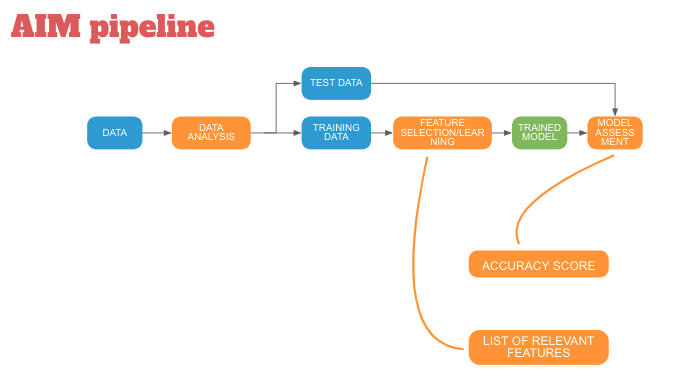

## Data loading

We will use the dataset we analysed during Lab 1, i.e., data from [The Cancer Genome Atlas (TGCA)](https://cancergenome.nih.gov).
Data input consists of genes, to which labels are associated. The dataset includes samples with 5 different labels corresponding to different tumor types, which are:
* BRCA (Breast Invasiva Carcinoma) - Primary Site: Breast
* COAD (Colon Adenocarcinoma) - Primary site: Colon
* KIRC (Kidney Renal Clear Cell Carcinoma) - Primary Site: Kidney
* LUAD (Lung Adenocarcinoma) - Primary Site: Bronchus and lung
* PRAD (Prostate Adenocarcinoma) - Primary Site: prostate gland.

First, download the dataset we are going to use at [`http://www.slipguru.unige.it/Data/TCGA-PANCAN-HiSeq-801x20531.tar.gz`](http://www.slipguru.unige.it/Data/TCGA-PANCAN-HiSeq-801x20531.tar.gz).
In order to do that you can either click on the link, exploit the capabilities of jupyter and run a bash command via "`!wget`" (recommended choice on Linux) or simply use Python (recommended choice on all other OS).

In [ ]:
import os
import tarfile
import urllib.request as urllib

# Download the full data file from the slipguru server
host = 'http://www.slipguru.unige.it/Data/'
filename = 'TCGA-PANCAN-HiSeq-801x20531.tar.gz'
urllib.urlretrieve (host+filename, filename)

# Extract the tar.gz archive into a folder
tar = tarfile.open(filename)
tar.extractall()
tar.close()

# Get the folder name
path = filename.split('.')[0]


Data is saved in the Files folder, you can reach it from the pannel one the left. Let's inspect the content of the folder `path`. 

In [ ]:
print('path:', path)
print('files:', os.listdir(path))

path: TCGA-PANCAN-HiSeq-801x20531
files: ['labels.csv', 'data.csv']


Let's now load the two files `data.csv` and `labels.csv` in two [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) objects. In order to do that we can take advantage of the function `pd.read_csv(filename, header=0, index_col=0)`. We can inspect the content of them by using the `head()` method.

In [ ]:
data = pd.read_csv(os.path.join(path, 'data.csv'), header=0, index_col=0)
print("Data matrix shape: {}".format(data.shape))
data.head()

Data matrix shape: (801, 20531)


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [ ]:
labels = pd.read_csv(os.path.join(path, 'labels.csv'), header=0, index_col=0)
print("The labels (correspondig to tumors) are: {}".format(np.unique(labels.values)))
labels.head()

The labels (correspondig to tumors) are: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


,Class
sample_0,PRAD
sample_1,LUAD
sample_2,PRAD
sample_3,PRAD
sample_4,BRCA


In this Lab, we will only consider two classes: BRCA (Breast Invasiva Carcinoma) and LUAD (Lung Adenocarcinoma). In order to do it, we have select a subset of data and labels corresponding to the samples with label "BRCA" or "LUAD". We can use `dataframe.loc`.

In [ ]:
BRCA_LUAD_patients = (labels['Class'] == 'BRCA') | (labels['Class'] == 'LUAD')
print(BRCA_LUAD_patients)

sample_0      False
sample_1       True
sample_2      False
sample_3      False
sample_4       True
              ...  
sample_796     True
sample_797     True
sample_798    False
sample_799    False
sample_800    False
Name: Class, Length: 801, dtype: bool


In [ ]:
data = data.loc[BRCA_LUAD_patients]
labels = labels.loc[BRCA_LUAD_patients]
print(data.shape, labels.shape)

(441, 20531) (441, 1)


# Part 1: Data Preparation


## Label conversion
The dataframe labels contain string ('BRCA', 'LUAD') which are not treatable objects. To use them in a ML framework, we need to convert them into numerical categories.

In [ ]:
label_names = np.unique(labels.values)
labels['Class'] = labels['Class'].astype("category").cat.codes
print("The labels are {}, corresponding to {}".format(np.unique(labels.values), label_names))
print(labels.head())

The labels are [0 1], corresponding to ['BRCA' 'LUAD']
           Class
sample_1       1
sample_4       0
sample_8       0
sample_10      0
sample_13      0


## Discard useless and corrupted data

Before building the models, it is always useful to perform the exploratory data analysis to have a look at the data and notice some data errors. The first thing to check is if there are features containing the same value for all samples: this features are not informatvie and can be discard. 


In [ ]:
statistics = data.describe()
constant_samples = (statistics.loc['min']==statistics.loc['max'])
print(constant_samples.head(10))
print('N. of constant features:', sum(constant_samples))
data = data.loc[:, (constant_samples == False)]
print('New data size:', data.shape)


gene_0    False
gene_1    False
gene_2    False
gene_3    False
gene_4    False
gene_5     True
gene_6    False
gene_7    False
gene_8    False
gene_9    False
dtype: bool
N. of constant features: 315
New data size: (441, 20216)


Then, we need to check if data contains NaN values. This is a common issue when we upload a table in which cells are not filled.

In [ ]:
data.isnull().sum().sum()


0

## Convert data in a suitable way for ML
Let's convert `DataFrame` objects into `numpy` arrays. We can do that using the method `to_numpy`. Then, we have to convert the string labels into numbers. 

In [ ]:
X, y = data.to_numpy(), labels.to_numpy()[:, 0]
print(X.shape, y.shape)

(441, 20216) (441,)


In [ ]:
# check if the dataset is balanced
from collections import Counter 
for k, v in Counter(y).items():
  print('Label', k, ' - N. of samples:', v)

Label 1  - N. of samples: 141
Label 0  - N. of samples: 300


## Features reduction
**ONLY for this course, to save time, we will use a random subset of features. This is NOT something you should do in real life as you could discard important information. Nonethelss, this will help us to run our experiments during the limited available time.**


In [ ]:
import random
nfeat = 500  # number of subset of features we will consider
all_idx_feat = [i for i in range(X.shape[1])] 
random.shuffle(all_idx_feat)
selected_idx_feat = all_idx_feat[:nfeat]
X_sampling = X[:, selected_idx_feat] # new input matrix 
print('Size of the sampled dataset:', X_sampling.shape)


Size of the sampled dataset: (441, 500)


In [ ]:
# take the name of the features
all_feature_names = data.columns
feature_names = all_feature_names[selected_idx_feat]
print(feature_names)

Index(['gene_1454', 'gene_5230', 'gene_5981', 'gene_10300', 'gene_9036',
       'gene_13841', 'gene_15733', 'gene_13286', 'gene_4377', 'gene_14489',
       ...
       'gene_2516', 'gene_17868', 'gene_14010', 'gene_18997', 'gene_7700',
       'gene_2384', 'gene_14471', 'gene_7509', 'gene_5797', 'gene_789'],
      dtype='object', length=500)


Let's visualize the dataset we obtained. 

Reduced X shape = (441, 2)


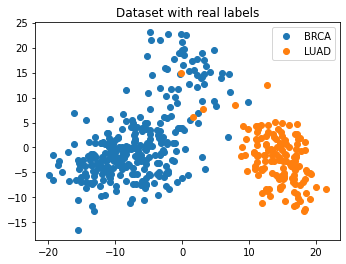

In [ ]:
from sklearn.decomposition import PCA
X_reduced = PCA(n_components=2).fit_transform(X_sampling, y)
print("Reduced X shape = {}".format(X_reduced.shape))
plt.figure(figsize=(12, 4))

# Real labels
plt.subplot(121)
for i in np.unique(y):
    idx = np.where(y == i)[0]
    plt.plot(X_reduced[idx, 0], X_reduced[idx, 1], 'o', label=label_names[i])
    plt.title('Dataset with real labels')
    plt.legend()

# Part 2: Feature selection
In the following we will perfrom feature selection by using three different approaches: i) Filters ii) Recursive Feature Elimination iii) Embedded methods. 
As all approaches employ the labels, we first need to split the dataset into training and testing. 


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sampling, y, test_size=0.20)
print(X_train.shape, X_test.shape)

(352, 500) (89, 500)


In some of the feature selection method we are going to employ, we need to define in advance the number of features to keep.

<b>What is a good number of feature to select?
Time to discuss pros and cons of using many and a little features.</b>  
  
There are some rules of thumb on how many features we need in the end:  
* $int(\frac{N_{samples}}{10})$ (Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from data (Vol. 4, p. 4). New York: AMLBook.)  
* $\sqrt{N_{samples}}$ (Hua, J., Xiong, Z., Lowey, J., Suh, E., & Dougherty, E. R. (2005). Optimal number of features as a function of sample size for various classification rules. Bioinformatics, 21(8), 1509-1515.)

In [ ]:
print ('Nmber of samples in training dataset: ', X_train.shape[0])
print ('Number of features to select according to Abu-Mostafa: ', int(X_train.shape[0]/10))
print ('Number of features to select according to Hua: ', int(X_train.shape[0]**0.5))

Nmber of samples in training dataset:  352
Number of features to select according to Abu-Mostafa:  35
Number of features to select according to Hua:  18


Which number of features will you chose?

## Filter methods
These methods select features based on their scores in various statistical tests taking into account their correlation with the outcome variable. The null hypothesis is that there is no difference between the groups: if the p-value is lower than 0.05 we reject the null hypothesis.
To choose which statistical test to use we have to be aware of the type of data and labels we are using. We can refer to the following table.


![picture](https://www.analyticsvidhya.com/wp-content/uploads/2016/11/FS1.png)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
filter_selector = SelectKBest(f_classif, k=35)
filter_selector.fit(X_train, y_train)

SelectKBest(k=35)

Let's investigate which are the most important features. We can use the get.support() method to return the important features. Specifically, it returns a matrix of True and False, where True corresponds to the selected features. We can also use the ranking_ attribute rankes the feature importance (rank=1 for selected feature).

In [ ]:
filter_support = filter_selector.get_support()
filter_selected_features = np.where(filter_support==True)[0]
filter_features_names = [feature_names[i] for i in filter_selected_features]
print('The most important features are:')
for f in filter_features_names:
  print(f)

The most important features are:
gene_2845
gene_18185
gene_16146
gene_19446
gene_19442
gene_10731
gene_13103
gene_12175
gene_17315
gene_5654
gene_5821
gene_16535
gene_2968
gene_1567
gene_18197
gene_5645
gene_9467
gene_17590
gene_9489
gene_15305
gene_4693
gene_970
gene_16245
gene_8441
gene_11346
gene_3053
gene_19542
gene_14747
gene_5651
gene_5620
gene_19148
gene_4833
gene_2448
gene_6040
gene_14768


In [ ]:
filter_importance = filter_selector.scores_
# normalize values between 0 and 1
m, M = min(filter_importance), max(filter_importance)
filter_importance = (filter_importance-m)/(M-m)

We can plot the feature importance by using the bar plots.

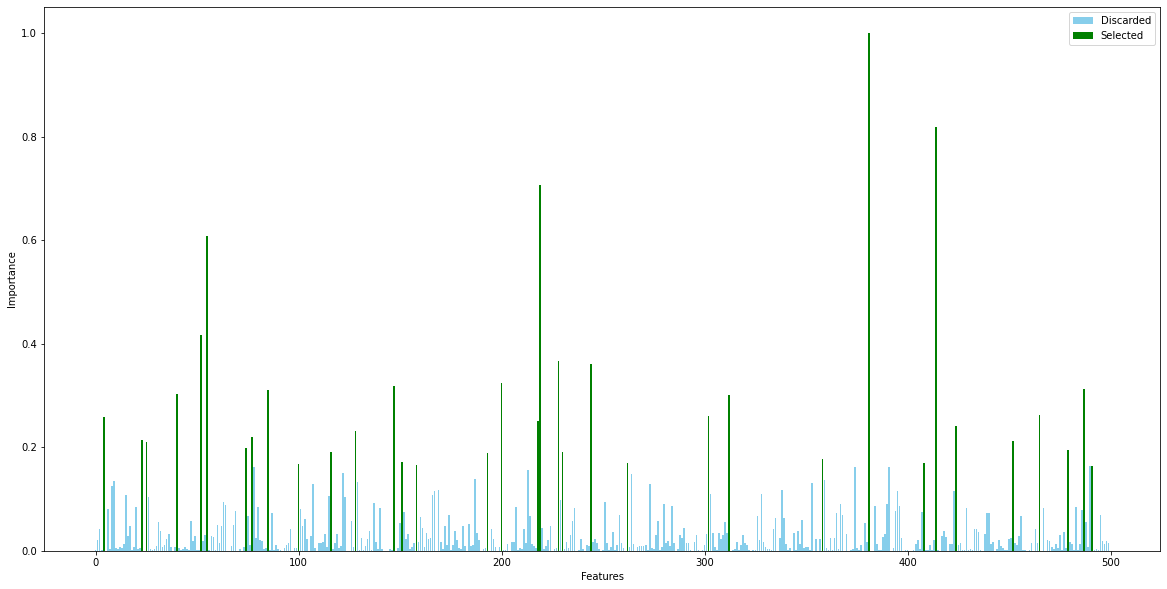

In [ ]:
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(filter_importance))], height=filter_importance, color='skyblue', label='Discarded')
plt.bar(filter_selected_features, height=filter_importance[filter_selected_features], color='green', label='Selected')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()

## Recursive Feature Elimination (RFE)
Below we implement Recursive Feature Elimination, RFE (https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), based on Support Vector machine Classifier, SVC (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). In this step, feature selection is based on the outcome, so simple models are built and those features that contribute the least to the model are removed recursively. 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

N_feat_to_select = 35
estimator = SVC(kernel='linear')
RFE_selector = RFE(estimator, n_features_to_select=N_feat_to_select, step=10)
RFE_selector = RFE_selector.fit(X_train, y_train)

Let's investigate which are the most important features. We can use the `get.support()` method to return the important features. Specifically, it returns a matrix of True and False, where True corresponds to the selected features. We can also use the `ranking_` attribute rankes the feature importance (rank=1 for selected feature).

In [ ]:
RFE_support = RFE_selector.get_support()
RFE_selected_features = np.where(RFE_support==True)[0]
RFE_features_names = [feature_names[i] for i in RFE_selected_features]
print('The most important features are:')
for f in RFE_features_names:
  print(f)


The most important features are:
gene_12866
gene_5712
gene_19446
gene_19442
gene_10731
gene_3847
gene_13062
gene_13103
gene_17315
gene_750
gene_18455
gene_5821
gene_16410
gene_2011
gene_2968
gene_18197
gene_5645
gene_9489
gene_15305
gene_3169
gene_14877
gene_970
gene_16245
gene_16150
gene_11346
gene_63
gene_19542
gene_13383
gene_5651
gene_5620
gene_17510
gene_19148
gene_6795
gene_2448
gene_6864


In [ ]:
ranks = RFE_selector.ranking_
print('The rank varies from {} to {}'.format(min(ranks), max(ranks)))

The rank varies from 1 to 25


We can transform the rank into weights, attributing the highest weight to the smallest rank. We can use the formula w = max(ranks) - rank + 1. We can also normalise the weights between 0 and 1 for a better reading.

In [ ]:
def from_rank_to_importance(rank):
  max = np.max(rank)
  w = [max - r + 1 for r in rank]
  m, M = np.min(w), np.max(w)
  return (w - m) / (M - m)

W = from_rank_to_importance(ranks)

We can plot the feature importance (W) by using the bar plots.

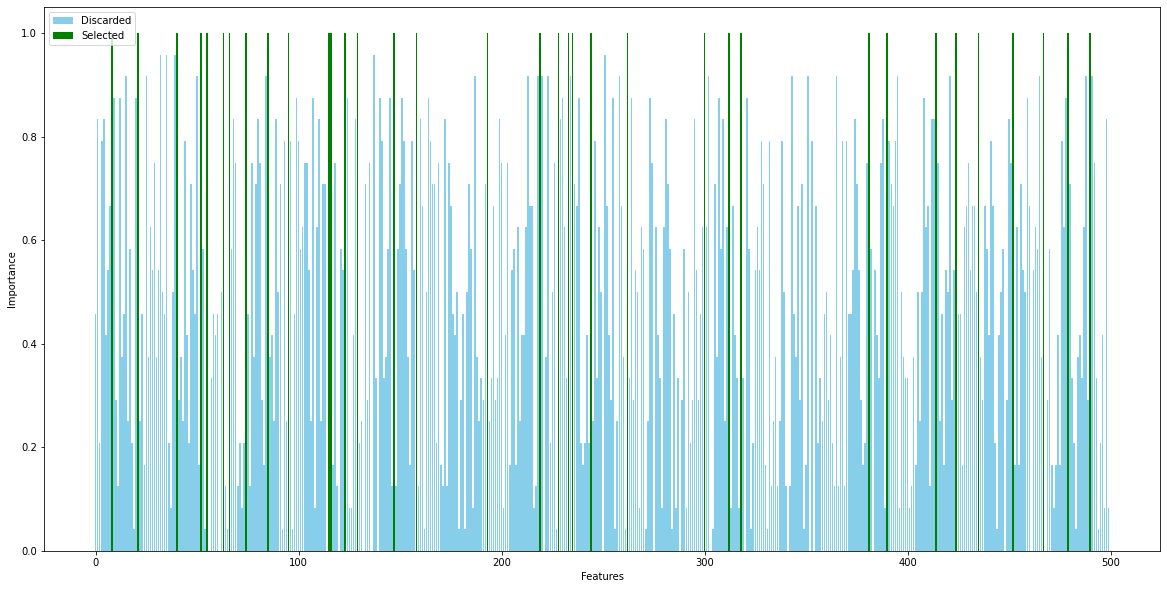

In [ ]:
plt.figure(figsize=(20,10))
plt.bar([i for i in range(len(W))], height=W, color='skyblue', label='Discarded')
plt.bar(RFE_selected_features, height=W[RFE_selected_features], color='green', label='Selected')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()

## Regularized methods
In the following, we will use LASSO method (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) which minimizes the following  objective function:

$$\frac{1}{2*n_{samples}} * ||y - Xw||^2_2 + alpha * ||w||_1$$.

alpha is a the regularization penalty whose optimal value can be find empirically. In order to do it, we will use inner k-fold cross validation that can be performed by the `LassoCV`function (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html).


In [ ]:
from sklearn.linear_model import LassoCV
regcv = LassoCV(cv=5, random_state=0, max_iter=10000).fit(X_train, y_train)
best_alpha = regcv.alpha_
print('best alpha:', best_alpha)

best alpha: 0.005814266500156961


In [ ]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)
coefficients = lasso_model.coef_
importance = np.abs(coefficients)
lasso_selected_features = np.where(importance != 0)[0]
lasso_features_names = [feature_names[i] for i in lasso_selected_features]
print('Lasso selected {} features'.format(len(lasso_selected_features)))
print('The most important features are:')
for f in lasso_features_names:
  print(f)

Lasso selected 106 features
The most important features are:
gene_6456
gene_2845
gene_12866
gene_17925
gene_10262
gene_543
gene_5712
gene_16146
gene_15074
gene_11605
gene_1472
gene_1939
gene_2054
gene_19446
gene_11787
gene_6944
gene_19442
gene_10731
gene_10800
gene_3847
gene_13062
gene_7174
gene_13103
gene_4295
gene_17315
gene_321
gene_750
gene_4248
gene_11792
gene_18455
gene_5821
gene_9543
gene_16535
gene_2011
gene_6381
gene_488
gene_6475
gene_2968
gene_1567
gene_7880
gene_18197
gene_2306
gene_10690
gene_10902
gene_9467
gene_1677
gene_9454
gene_8132
gene_12350
gene_17590
gene_9489
gene_10155
gene_15305
gene_4693
gene_3169
gene_11464
gene_14877
gene_970
gene_11797
gene_13610
gene_13646
gene_16245
gene_4178
gene_7706
gene_8976
gene_16027
gene_19889
gene_16150
gene_17928
gene_17410
gene_11346
gene_891
gene_18227
gene_4696
gene_13150
gene_9267
gene_3732
gene_18422
gene_12865
gene_4020
gene_9041
gene_19542
gene_13383
gene_15806
gene_15780
gene_15988
gene_2855
gene_5651
gene_5620
gene_1828


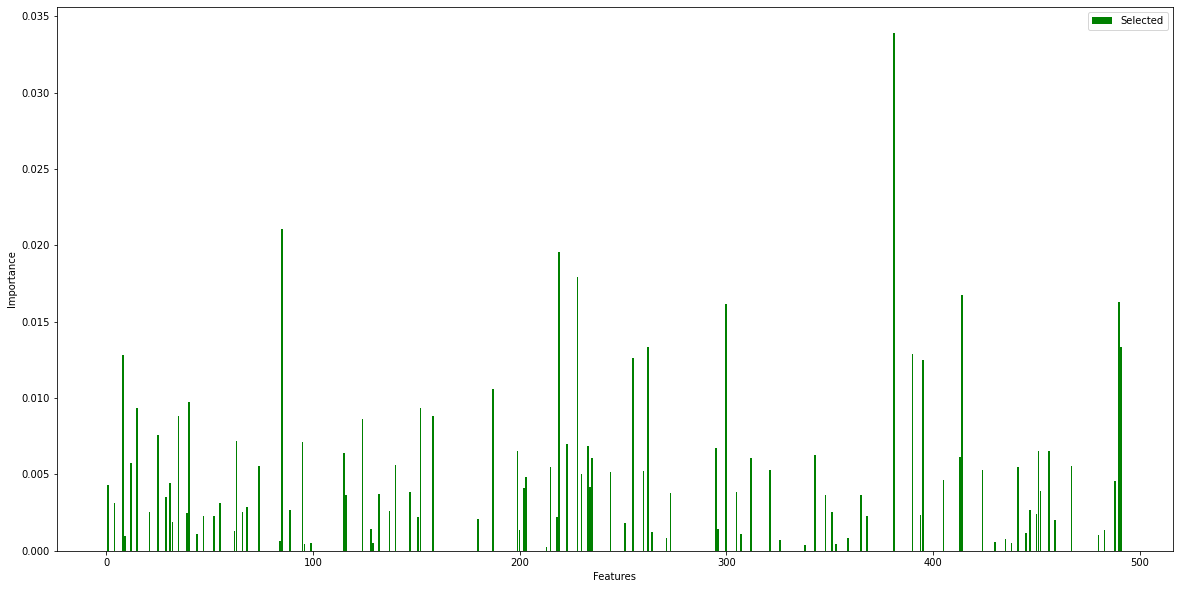

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(lasso_selected_features, height=importance[lasso_selected_features], color='green', label='Selected')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()

# Part 3: Methods comparison
Are those really the important features?
First, we can check if those methods selected similar features. Second, we can compare the performance models trained on different input:
* The input matrix with all features (without selection);
* The input matrix with features selected randomly.
* The input matrix with features selected by the filter method;
* The input matrix with features selected by RFE;
* The input matrix with features selected by LASSO;



## Selected features comparison

[Text(0.5, 0, 'gene_9874'),
 Text(5.5, 0, 'gene_6456'),
 Text(10.5, 0, 'gene_684'),
 Text(15.5, 0, 'gene_943'),
 Text(20.5, 0, 'gene_2845'),
 Text(25.5, 0, 'gene_3496'),
 Text(30.5, 0, 'gene_19765'),
 Text(35.5, 0, 'gene_5676'),
 Text(40.5, 0, 'gene_12866'),
 Text(45.5, 0, 'gene_17925'),
 Text(50.5, 0, 'gene_11732'),
 Text(55.5, 0, 'gene_20153'),
 Text(60.5, 0, 'gene_10262'),
 Text(65.5, 0, 'gene_2090'),
 Text(70.5, 0, 'gene_15962'),
 Text(75.5, 0, 'gene_543'),
 Text(80.5, 0, 'gene_11917'),
 Text(85.5, 0, 'gene_8206'),
 Text(90.5, 0, 'gene_4081'),
 Text(95.5, 0, 'gene_9338'),
 Text(100.5, 0, 'gene_14616'),
 Text(105.5, 0, 'gene_5712'),
 Text(110.5, 0, 'gene_4002'),
 Text(115.5, 0, 'gene_18185'),
 Text(120.5, 0, 'gene_18467'),
 Text(125.5, 0, 'gene_16146'),
 Text(130.5, 0, 'gene_5884'),
 Text(135.5, 0, 'gene_9257'),
 Text(140.5, 0, 'gene_16218'),
 Text(145.5, 0, 'gene_15074'),
 Text(150.5, 0, 'gene_2606'),
 Text(155.5, 0, 'gene_11605'),
 Text(160.5, 0, 'gene_1472'),
 Text(165.5, 0, 'gen

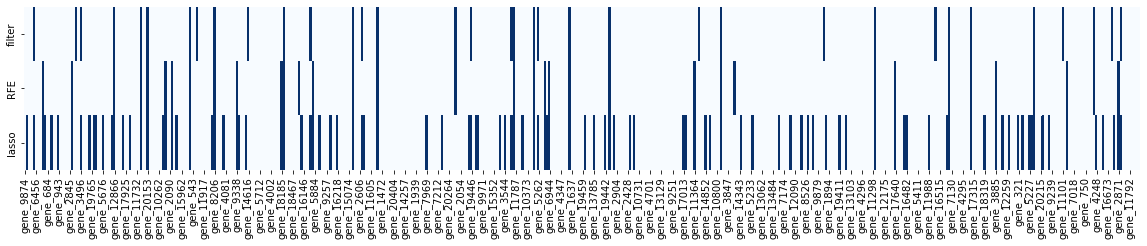

In [ ]:
selected_features = np.zeros([3, X_sampling.shape[1]])
selected_features[0, filter_selected_features] = 1
selected_features[1, RFE_selected_features] = 1
selected_features[2, lasso_selected_features] = 1
plt.figure(figsize=(20,3))
img = sb.heatmap(selected_features,cmap='Blues', cbar=False)
img.yaxis.set_ticklabels(['filter', 'RFE', 'lasso'])
img.xaxis.set_ticklabels(feature_names, rotation=90)


## Classification models comparison


In [ ]:
# model using on all features: 
all_feat_model = SVC()
all_feat_model.fit(X_train, y_train)
all_feat_test_prediction = all_feat_model.predict(X_test)
all_feat_model_acc = accuracy_score(y_test, all_feat_test_prediction)

In [ ]:
# select random features:
indices = [i for i in range(nfeat)]
random.shuffle(indices)
random_selected_features = indices[:N_feat_to_select]

# model using random selected features:
random_feat_model = SVC()
random_feat_model.fit(X_train[:, random_selected_features], y_train)
random_feat_test_prediction = random_feat_model.predict(X_test[:, random_selected_features])
random_feat_model_acc = accuracy_score(y_test, random_feat_test_prediction)


In [ ]:
# model based on features selected by filter methods
filter_model = SVC()
filter_model.fit(X_train[:, filter_selected_features], y_train)
filter_test_prediction = filter_model.predict(X_test[:, filter_selected_features])
filter_model_acc = accuracy_score(y_test, filter_test_prediction)

In [ ]:
# model based on RFE:
RFE_model = SVC()
RFE_model.fit(X_train[:, RFE_selected_features], y_train)
RFE_test_prediction = RFE_model.predict(X_test[:, RFE_selected_features])
RFE_model_acc = accuracy_score(y_test, RFE_test_prediction)


In [ ]:
# LASSO model
lasso_prediction_test = lasso_model.predict(X_test).round()
lasso_model_acc = accuracy_score(y_test, lasso_prediction_test)

In [ ]:
print('Testing accuracy of SVM model based on')
print('')
print('All features:', all_feat_model_acc)
print('Random selected features:', random_feat_model_acc)
print('Filter method selected features:', filter_model_acc)
print('RFE Selected features:', RFE_model_acc)
print('Lasso:', lasso_model_acc)


Testing accuracy of SVM model based on

All features: 1.0
Random selected features: 0.9887640449438202
Filter method selected features: 1.0
RFE Selected features: 1.0
Lasso: 1.0


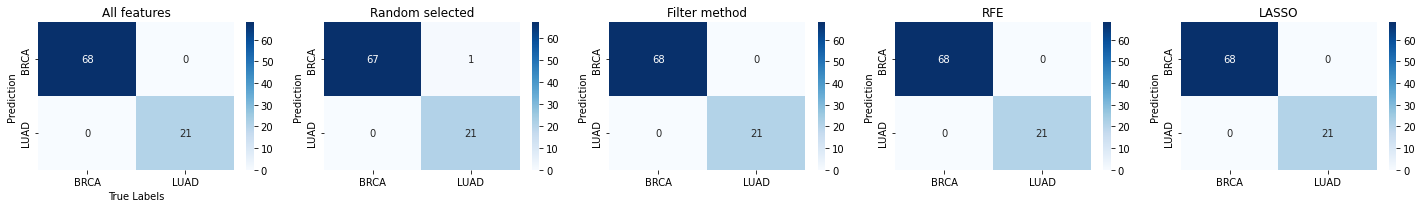

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sb

all_cm = confusion_matrix(y_test, all_feat_test_prediction)
random_cm = confusion_matrix(y_test, random_feat_test_prediction)
filter_cm = confusion_matrix(y_test, filter_test_prediction)
RFE_cm = confusion_matrix(y_test, RFE_test_prediction)
lasso_cm = confusion_matrix(y_test, lasso_prediction_test)

plt.figure(figsize=(20, 3))
plt.subplot(151)
plt.title('All features')
img = sb.heatmap(all_cm,annot=True,cmap='Blues')
img.set(xlabel="True Labels", ylabel="Prediction")
img.xaxis.set_ticklabels(label_names)
img.yaxis.set_ticklabels(label_names)
plt.subplot(152)
plt.title('Random selected')
img = sb.heatmap(random_cm,annot=True,cmap='Blues')
img.set(ylabel="Prediction")
img.xaxis.set_ticklabels(label_names)
img.yaxis.set_ticklabels(label_names)
plt.subplot(153)
plt.title('Filter method')
img = sb.heatmap(filter_cm,annot=True,cmap='Blues')
img.set(ylabel="Prediction")
img.xaxis.set_ticklabels(label_names)
img.yaxis.set_ticklabels(label_names)
plt.subplot(154)
plt.title('RFE')
img = sb.heatmap(RFE_cm,annot=True,cmap='Blues')
img.set(ylabel="Prediction")
img.xaxis.set_ticklabels(label_names)
img.yaxis.set_ticklabels(label_names)
plt.subplot(155)
plt.title('LASSO')
img = sb.heatmap(lasso_cm,annot=True,cmap='Blues')
img.set(ylabel="Prediction")
img.xaxis.set_ticklabels(label_names)
img.yaxis.set_ticklabels(label_names)
plt.tight_layout()